# RL BiasCoin eGreedy UCB

In [ ]:
import matplotlib.pyplot as plt
import random
import math

from matplotlib.pyplot import gcf
fig = gcf()
fig.set_size_inches(58.5, 50.5)

<Figure size 4212x3636 with 0 Axes>

In [ ]:
class NormalArm():
  def __init__(self, mu, sigma):
    self.mu = mu
    self.sigma = sigma
  
  def draw(self):
    return random.gauss(self.mu, self.sigma)

In [ ]:
def ind_max(x):
  m = max(x)
  return x.index(m)

class EpsilonGreedy():
  def __init__(self, epsilon, counts, values):
    self.epsilon = epsilon
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    if random.random() > self.epsilon:
      return ind_max(self.values)
    else:
      return random.randrange(len(self.values))
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

In [ ]:
def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(len(probs)):
    prob = probs[i]
    cum_prob += prob
    if cum_prob > z:
      return i

  return len(probs) - 1

class Exp3():
  def __init__(self, gamma, weights):
    self.gamma = gamma
    self.weights = weights
    return
  
  def initialize(self, n_arms):
    self.weights = [1.0 for i in range(n_arms)]
    return
  
  def select_arm(self):
    n_arms = len(self.weights)
    total_weight = sum(self.weights)
    probs = [0.0 for i in range(n_arms)]
    for arm in range(n_arms):
      probs[arm] = (1 - self.gamma) * (self.weights[arm] / total_weight)
      probs[arm] = probs[arm] + (self.gamma) * (1.0 / float(n_arms))
    return categorical_draw(probs)
  
  def update(self, chosen_arm, reward):
    n_arms = len(self.weights)
    total_weight = sum(self.weights)
    probs = [0.0 for i in range(n_arms)]
    for arm in range(n_arms):
      probs[arm] = (1 - self.gamma) * (self.weights[arm] / total_weight)
      probs[arm] = probs[arm] + (self.gamma) * (1.0 / float(n_arms))
    
    x = reward / probs[chosen_arm]
    
    growth_factor = math.exp((self.gamma / n_arms) * x)
    self.weights[chosen_arm] = self.weights[chosen_arm] * growth_factor

In [ ]:
def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(len(probs)):
    prob = probs[i]
    cum_prob += prob
    if cum_prob > z:
      return i
  
  return len(probs) - 1

class Softmax:
  def __init__(self, temperature, counts, values):
    self.temperature = temperature
    self.counts = counts
    self.values = values
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return
  
  def select_arm(self):
    z = sum([math.exp(v / self.temperature) for v in self.values])
    probs = [math.exp(v / self.temperature) / z for v in self.values]
    return categorical_draw(probs)

  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

In [ ]:
def ind_max(x):
  m = max(x)
  return x.index(m)

class UCB2(object):
  def __init__(self, alpha, counts, values):
    """
    UCB2 algorithm. Implementation of the slides at:
    http://lane.compbio.cmu.edu/courses/slides_ucb.pdf
    """
    self.alpha = alpha
    self.counts = counts
    self.values = values
    self.__current_arm = 0
    self.__next_update = 0
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    self.r = [0 for col in range(n_arms)]
    self.__current_arm = 0
    self.__next_update = 0
  
  def __bonus(self, n, r):
    tau = self.__tau(r)
    bonus = math.sqrt((1. + self.alpha) * math.log(math.e * float(n) / tau) / (2 * tau))
    return bonus
  
  def __tau(self, r):
    return int(math.ceil((1 + self.alpha) ** r))
  
  def __set_arm(self, arm):
    """
    When choosing a new arm, make sure we play that arm for
    tau(r+1) - tau(r) episodes.
    """
    self.__current_arm = arm
    self.__next_update += max(1, self.__tau(self.r[arm] + 1) - self.__tau(self.r[arm]))
    self.r[arm] += 1
  
  def select_arm(self):
    n_arms = len(self.counts)
    
    # play each arm once
    for arm in range(n_arms):
      if self.counts[arm] == 0:
        self.__set_arm(arm)
        return arm
    
    # make sure we aren't still playing the previous arm.
    if self.__next_update > sum(self.counts):
      return self.__current_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(self.counts)
    for arm in range(n_arms):
      bonus = self.__bonus(total_counts, self.r[arm])
      ucb_values[arm] = self.values[arm] + bonus
    
    chosen_arm = ind_max(ucb_values)
    self.__set_arm(chosen_arm)
    return chosen_arm
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value

In [ ]:
def run_scenario(change_of_distribution=False):
  #Initialize arms with mean and standard deviation
  arm1 = NormalArm(0.1,2)
  arm2 = NormalArm(0.2,2)
  arm3 = NormalArm(0.3,2)
  arm4 = NormalArm(0.4,2)
  arm5 = NormalArm(0.5,2)
  arm6 = NormalArm(0.6,2)
  arm7 = NormalArm(0.7,2)
  arm8 = NormalArm(0.8,2) #<------------Optimal Strategy
  arms = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8]

  n_arms = len(arms)
  algo1 = EpsilonGreedy(0.05, [], [])
  algo2 = Exp3(.05, [])
  algo3 = Softmax(.25, [], [])
  algo4 = UCB2(.125, [], [])

  algorithms = [algo1, algo4]
  algorithm_rewards = []
  algorithm_arm_selections = []

  for algo in algorithms:
    algo.initialize(n_arms)
    avg_rewards = [0]
    num_sims = 5000
    rewards = []
    arm_selections = []

    for t in range(1, num_sims):
      #Change the underlying distribution of rewards
      if t == num_sims/2 and change_of_distribution:
        arm1 = NormalArm(0.8,2) #<------------Optimal Strategy
        arm2 = NormalArm(0.6,2)
        arm3 = NormalArm(0.7,2)
        arm4 = NormalArm(0.4,2)
        arm5 = NormalArm(0.3,2)
        arm6 = NormalArm(0.2,2)
        arm7 = NormalArm(0.1,2)
        arm8 = NormalArm(0.5,2)
        arms = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8]
        algo.initialize(n_arms)

      chosen_arm = algo.select_arm()
      arm_selections.append(chosen_arm+1)
      reward = arms[chosen_arm].draw()
      rewards.append(reward)
      running_avg = (avg_rewards[-1]*(t-1)+reward)/float(t)
      avg_rewards.append(running_avg)
      algo.update(chosen_arm, reward)

    algorithm_rewards.append(avg_rewards)
    algorithm_arm_selections.append(arm_selections)

  plt.figure(figsize=(10,12))
  plt.subplot(221)
  plt.plot(algorithm_rewards[0], label='Average rewards')
  if change_of_distribution:
    plt.axvline(x=num_sims/2, color='r')
  plt.ylabel('Average Reward for Epsilon-Greedy')
  plt.axis([0,num_sims,0,.8])

  plt.subplot(223)
  plt.scatter(range(num_sims-1),algorithm_arm_selections[0],  s=.1)
  plt.axis([0, num_sims, 0, 9])
  if change_of_distribution:
    plt.axvline(x=num_sims/2, color='r')
  plt.ylabel('Arm Selection')

  plt.subplot(222)
  plt.plot(algorithm_rewards[1], label='Average rewards')
  if change_of_distribution:
    plt.axvline(x=num_sims/2, color='r')
  plt.ylabel('Average Reward for UCB1')
  plt.axis([0,num_sims,0,.8])

  plt.subplot(224)
  plt.scatter(range(num_sims-1),algorithm_arm_selections[1],  s=.1)
  plt.axis([0, num_sims, 0, 9])
  if change_of_distribution:
    plt.axvline(x=num_sims/2, color='r')
  plt.ylabel('Arm Selection')
  plt.show()

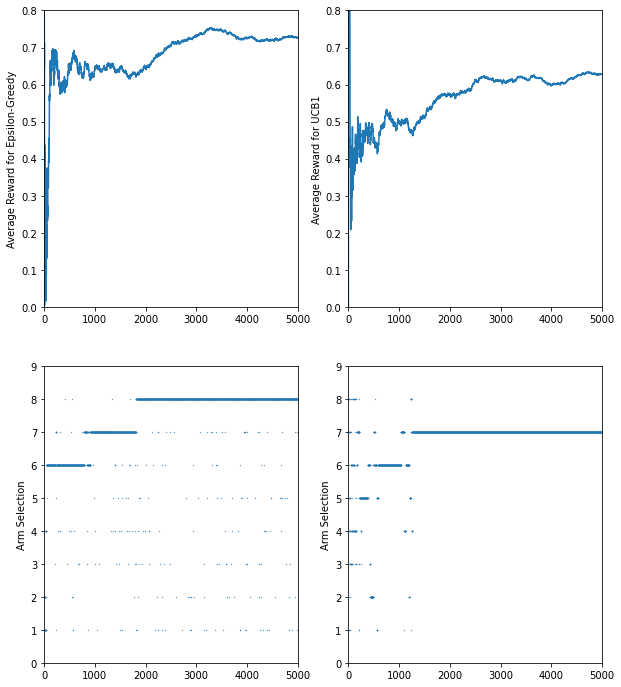

In [ ]:
run_scenario()

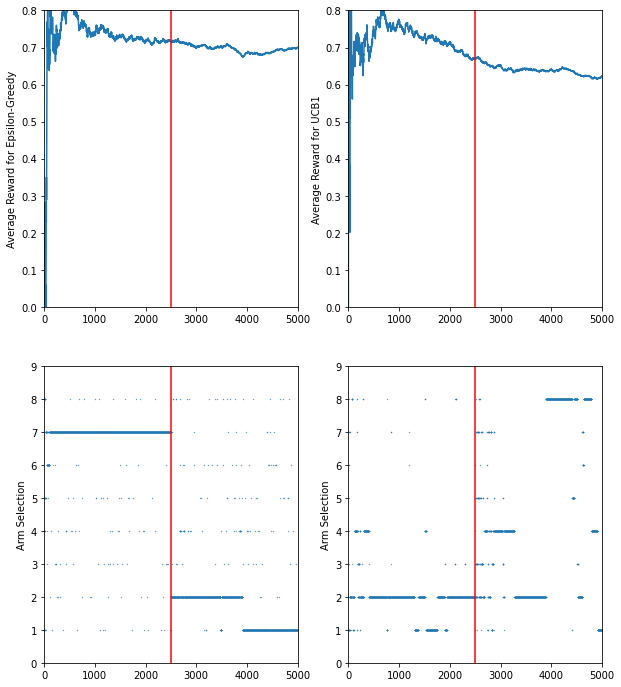

In [ ]:
run_scenario(change_of_distribution=True)